In [7]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, Sequence
from keras import backend as K 
from skimage.io import imread, imsave
from skimage.external.tifffile import TiffWriter
from scipy.ndimage import interpolation
from copy import deepcopy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
import time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/data')
img_train_path = ('/content/gdrive/My Drive/data/2Dimages/train_img')
lesion_train_path = ('/content/gdrive/My Drive/data/2Dimages/train_lesion')
img_valid_path = ('/content/gdrive/My Drive/data/2Dimages/valid_img')
lesion_valid_path = ('/content/gdrive/My Drive/data/2Dimages/valid_lesion')
img_test_path = ('/content/gdrive/My Drive/data/2Dimages/test_img')
lesion_test_path = ('/content/gdrive/My Drive/data/2Dimages/test_lesion')

In [14]:
seed = 2021
img_size = (128, 64)
data_args = dict(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

img_train_final = ImageDataGenerator(**data_args)
lesion_train_final = ImageDataGenerator(**data_args)
img_valid_final = ImageDataGenerator(rescale=1./255) 
lesion_valid_final = ImageDataGenerator(rescale=1./255)
img_test_final = ImageDataGenerator(rescale=1./255)
lesion_test_final = ImageDataGenerator(rescale=1./255)

flow_args = dict(target_size=img_size,
                 color_mode = 'grayscale',
                 batch_size = 32,
                 class_mode = None,
                 seed = seed)

img_train_generator = img_train_final.flow_from_directory(img_train_path, **flow_args)
lesion_train_generator = lesion_train_final.flow_from_directory(lesion_train_path, **flow_args)
train_generator = zip(img_train_generator, lesion_train_generator)
###############################################################################################
img_valid_generator = img_valid_final.flow_from_directory(img_valid_path, **flow_args)
lesion_valid_generator = lesion_valid_final.flow_from_directory(lesion_valid_path, **flow_args)
valid_generator = zip(img_valid_generator, lesion_valid_generator)
###############################################################################################
img_test_generator = img_test_final.flow_from_directory(img_test_path, **flow_args)
lesion_test_generator = lesion_test_final.flow_from_directory(lesion_test_path, **flow_args)
test_generator = zip(img_test_generator, lesion_test_generator)


x = img_train_generator.__getitem__(0)
print(x.shape)
y = lesion_train_generator.__getitem__(0)
print(y.shape)

Found 35 images belonging to 1 classes.
Found 35 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 79 images belonging to 1 classes.
Found 79 images belonging to 1 classes.
(32, 128, 64, 1)
(32, 128, 64, 1)


In [15]:
def check_masks(data_batch,labels_batch,predictions=None):
  if predictions is None:
    predictions = np.zeros_like(labels_batch)
  plt.figure(figsize=(8,8))
  
  for i, (img, mask, pred) in enumerate(zip(data_batch, labels_batch, predictions)):
        # image only
        plt.subplot(3,3,i+1)
        h = plt.imshow(np.squeeze(img), aspect='auto')
        h.set_cmap('gray')
        plt.axis('off') 
        plt.title('image %d'% (i+1))

        # overlay mask + image
        plt.subplot(3,3,i+4)
        merged = 0.7*np.tile(img, (1,1,3))
        if pred.max()==0:
            merged[:,:,1] += 0.7*np.squeeze(mask)
        else:
            merged[:,:,0] += 0.7*np.squeeze(pred)    
        merged[merged>1] = 1

        h = plt.imshow(merged, aspect='auto')
        plt.axis('off')
        if pred.max()==0:
            plt.title('mask with image %d'% (i+1))
        else:
            plt.title('Predictions')           
        
            
        # overlay mask + prediction
        plt.subplot(3,3,i+7)
        masks = np.concatenate([pred, np.zeros(mask.shape[:2]+(2,))], axis=2)
        masks[:,:,1] += np.squeeze(mask)
        plt.imshow(masks, aspect='auto')
        plt.axis('off')
        if pred.max()>0:
          plt.title('Dice: %1.3f' % dice(mask, pred))
        else: 
          plt.title('mask %d'% (i+1))

        if i==2:
            break 


data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


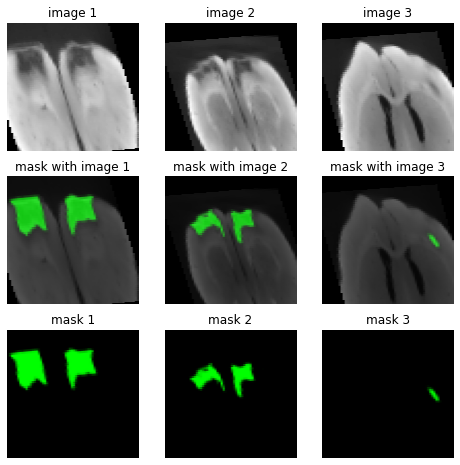

In [16]:
# check dataset
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

check_masks(data_batch, labels_batch)

In [17]:
one_weight = 0.95 # class weights
zero_weight = 0.05

def weighted_binary_crossentropy(y_true, y_pred):

    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

In [18]:
smooth = 1.

def dice(y_true, y_pred): # for numpy arrays
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = np.sum(y_true_f*y_pred_f)
    if np.sum(y_true_f + y_pred_f)==0:
        return 1.0
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    if K.sum(y_true_f + y_pred_f)==0:
        return 1.0
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [20]:
def Unet_2d(loss_fn=dice_coef_loss, lr=1e-3, act='relu', init='he_normal', pad='same', dropout=False):
    inputs = Input(img_size + (1,))
        
    c1 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (inputs)
    c1 = Dropout(0.1) (c1) if dropout else c1
    c1 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p1)
    c2 = Dropout(0.1) (c2) if dropout else c2
    c2 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p2)
    c3 = Dropout(0.2) (c3) if dropout else c3
    c3 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p3)
    c4 = Dropout(0.2) (c4) if dropout else c4
    c4 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p4)    
    c5 = Dropout(0.3) (c5)  if dropout else c5
    c5 = Conv2D(256, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=pad) (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u6)
    c6 = Dropout(0.2) (c6) if dropout else c6
    c6 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=pad) (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u7)
    c7 = Dropout(0.2) (c7) if dropout else c7
    c7 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=pad) (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u8)
    c8 = Dropout(0.1) (c8) if dropout else c8
    c8 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=pad) (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u9)
    c9 = Dropout(0.1) (c9) if dropout else c9
    c9 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=lr), loss=loss_fn, metrics=[dice_coef])
    model.summary()
    
    return model

In [ ]:
K.clear_session()
model = Unet_2d(loss_fn=weighted_binary_crossentropy)

In [23]:
checkpoint = ModelCheckpoint(filepath='U_net.h5', monitor='val_loss', save_best_only=True)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=10,
    verbose=1,
    callbacks=[checkpoint])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
30/30 [==============================] - 152s 5s/step - loss: 0.0453 - dice_coef: 0.1602 - val_loss: 0.0336 - val_dice_coef: 0.1206
Epoch 2/20
30/30 [==============================] - 48s 2s/step - loss: 0.0318 - dice_coef: 0.2253 - val_loss: 0.0277 - val_dice_coef: 0.1499
Epoch 3/20
30/30 [==============================] - 48s 2s/step - loss: 0.0259 - dice_coef: 0.2694 - val_loss: 0.0174 - val_dice_coef: 0.2726
Epoch 4/20
30/30 [==============================] - 48s 2s/step - loss: 0.0204 - dice_coef: 0.3833 - val_loss: 0.0142 - val_dice_coef: 0.4807
Epoch 5/20
30/30 [==============================] - 48s 2s/step - loss: 0.0161 - dice_coef: 0.4919 - val_loss: 0.0114 - val_dice_coef: 0.5154
Epoch 6/20
30/30 [==============================] - 48s 2s/step - loss: 0.0131 - dice_coef: 0.6126 - val_loss: 0.0104 - val_dice_coef: 0.6087
Epoch 7/20
30/30 [==============================] - 48s 2s/step - loss: 0.0126 - dice_coef: 0.6434 - val_loss: 0.0113 - val_dice_coef: 0.6625
Epoch

In [24]:
def plot_performance(history):
    dicec = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(dicec))
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(epochs, dicec, label='Training dice')
    plt.plot(epochs, val_dice, label='Validation dice')
    plt.xlabel("Num of Epochs")
    plt.ylabel("dice")
    plt.title('Training and validation dice')
    plt.legend()

    plt.subplot(1,2,2)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

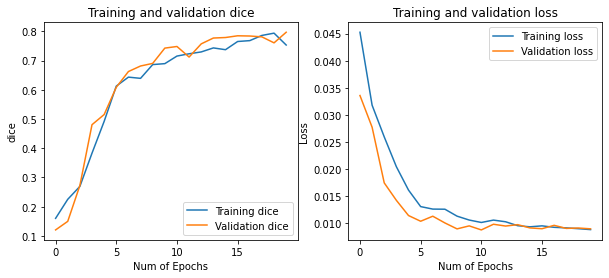

In [25]:
plot_performance(history)

In [26]:
# load best model
model.load_weights('U_net.h5')

data batch shape: (3, 128, 64, 1)
labels batch shape: (3, 128, 64, 1)


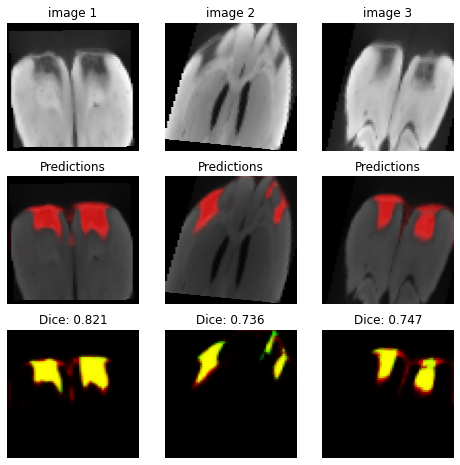

In [27]:
# training set performance
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
check_masks(data_batch, labels_batch, predict_batch)

data batch shape: (14, 128, 64, 1)
labels batch shape: (14, 128, 64, 1)


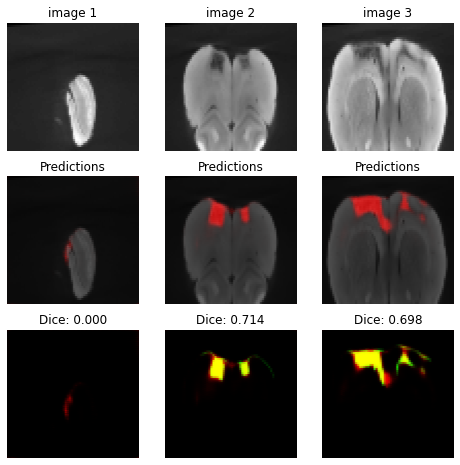

In [29]:
# validation set performance
for data_batch, labels_batch in valid_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
check_masks(data_batch, labels_batch, predict_batch)

data batch shape: (15, 128, 64, 1)
labels batch shape: (15, 128, 64, 1)


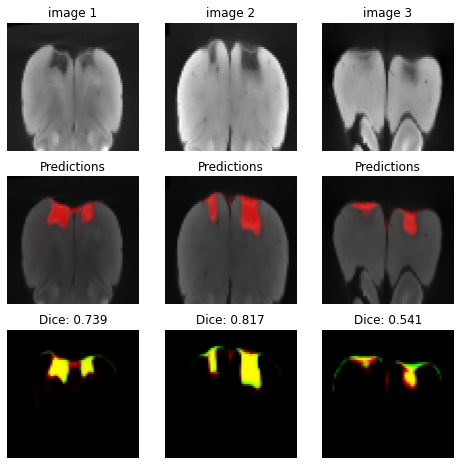

In [44]:
# test set performance
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
check_masks(data_batch, labels_batch, predict_batch)